<a href="https://colab.research.google.com/github/bgalerne/ed_deep_learning/blob/main/2_ed_DL_transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning for Computer Vision (Tutorial and Exercices)


This is a modified version of PyTorch tutorial:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

* License: BSD
* Author of original tutorial: Sasank Chilamkurthy https://chsasank.github.io
* Adapated and extended for teaching purpose by [Bruno Galerne](https://www.idpoisson.fr/galerne)


## Check that the colab has a GPU:
(otherwise go to Eit->Notebook properties ->...)

In [ ]:
!nvidia-smi

In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
!wget 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
!unzip -nq hymenoptera_data.zip
!ls
!ls hymenoptera_data
!ls hymenoptera_data/train/


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('Class names are: ', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the pretrained convnet

Load a pretrained model and reset final fully connected layer.

Here we use **ResNet18**.

The original architecture of which is designed for the classification of 1000 ImageNet classes. The architecture is a 18-layer version of the one above (from the original paper: https://arxiv.org/pdf/1512.03385.pdf[texte du lien](https:// [texte du lien](https:// [texte du lien](https://))))



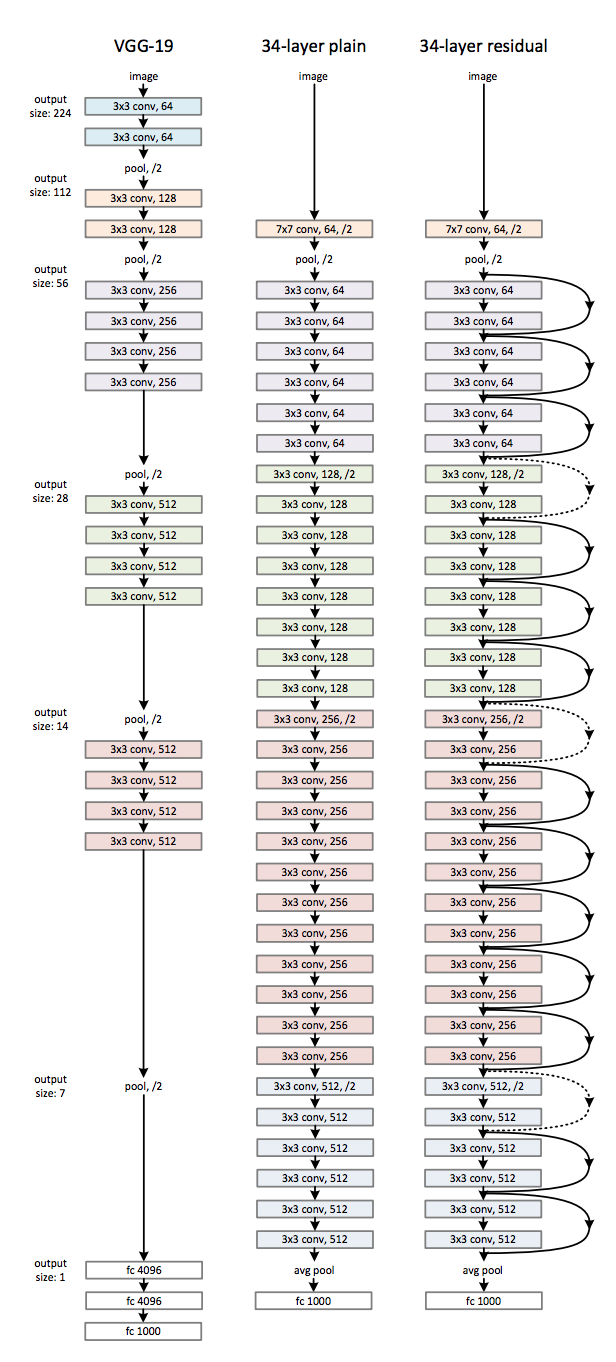





In short after a sequence of convolution layers and residual connections, the classification is done by a single fully connected layer after average pooling of spatial features.

Let's have a look at the model.
A first way is to use the print function of PyTorch:

In [ ]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)


Another way to look at a model is to use the torchsummary lib that reproduces a keras functionnality:

In [ ]:
import torchsummary
torchsummary.summary(model_ft.to(device), input_size=(3,224,224))


What is important for classification is the last layer:
>   (fc): Linear(in_features=512, out_features=1000, bias=True)


resnet18 extracts 512 features from images, then uses a linear layer with 1000 outputs for a classification (with crossentropy loss that includes the softmax layer).


### Adapting the model to our task:

We need to adapt the network to our classification with only 2 classes (bees and ants).

In [ ]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
print(model_ft.fc)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than 2
minutes.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

# Pretrained ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

#Exercise 1: Discussion

1. Explain how the model given by the ```train_model``` function is selected.
2. What is missing here to assess the performance of this model (output of train function)?

#Exercise 2: Apply the same approach to VGG-19

In this exercice we will use the pretrained VGG19 model as a fixed feature extractor. However the classifier part of VGG19 is more complex than the one of Resnet18.


1. Adapt and retrain the last linear layer of the classifier part of the VGG19 model (see above cell).
2. Adapt the last layer and retrain all the parameters of the VGG19 model (fine tuning of all parameters).
3. Compare the results of both approaches.


In [ ]:
model_conv = torchvision.models.vgg19(pretrained=True)
print("Full model")
print(model_conv)

print("\nClassifier part")
print(model_conv.classifier)
print("\nLast layer")
print(model_conv.classifier[6])


In [ ]:
#TODO.

#Exercice 3: Classification of another dataset

In this exercise you will classify pictures of flowers.
First we describe the dataset and provide functions for loading the dataset in compatible form for PyTorch.

The exercise really begins once the dataloaders are defined.


### A little perspective:
Quoting the research work related to the database:

> *Automated Flower Classification over a Large Number of Classes*,
M. Nilsback, A. Zisserman,
Indian Conference on Computer Vision, Graphics and Image Processing, Dec 2008

https://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/

> Finally, using the features computed in this paper and the multiple kernel classifier leads to a performance of 88.33±0.3%. This is the best performance todate reported on the 17 class flower dataset.

You should get a better performance using off-the-shelf deep neural networks for image classification.
This shows once again the performance gain that deep neural networks allow for.


## 17 Category Flower Dataset
Dataset description:

 * Source: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html
 * 17 classes, 80 images per classes (total: 17*80 = 1360 images)
 * Images 1 to 80 are class 0, 81 to 160 are class 1 etc...
 * Classes in the image file order are

        classes = ['Daffodil','Snowdrop', 'Lily_Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts_Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']
 * 3 different train / val / test data splits are given by the authors in ```datasplits.mat```.

In [ ]:
# get data:
!wget -c https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
!wget -c https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat
!tar zxf 17flowers.tgz
!ls
# should have a jpg/ folder

In [ ]:
import scipy.io
ds = scipy.io.loadmat('datasplits.mat')
print(ds.keys())
#print(ds['trn1'])
print('total images for split 1: ', ds['trn1'].size + ds['tst1'].size + ds['val1'].size)

classes = ['Daffodil','Snowdrop', 'Lily_Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts_Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

## Visualize one image per class from the dataset:

In [ ]:
import imageio

for i in range(17):
  plt.imshow(imageio.imread('jpg/image_'+str(80*i+1+np.random.randint(80)).zfill(4)+'.jpg'))
  plt.title(classes[i])
  plt.show()

## Create generic dataset structure for torchvision.datasets.ImageFolder

Quoting the documentation for [```torchvision.datasets.ImageFolder```](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder):

> A generic data loader where the images are arranged in this way:
  ```
   root/dog/xxx.png
   root/dog/xxy.png
   root/dog/xxz.png
   ...
   root/cat/123.png
   root/cat/nsdf3.png
   root/cat/asd932_.png
   ```

In [ ]:
# create folder structure for torchvision.datasets.ImageFolder
rootdir = 'flowers17'
os.makedirs(rootdir, exist_ok=True)
phases = ['train', 'test', 'val']
datadirs = [os.path.join(rootdir, x) for x in phases]
print(datadirs)
for dir in datadirs:
  os.makedirs(dir, exist_ok=True)
  for cl in classes:
    os.makedirs(os.path.join(dir,cl), exist_ok=True)

# go through the train/val/test splitting #1 of the database and copy image files:
imgnumbers = [ds['trn1'].ravel(), ds['tst1'].ravel(), ds['val1'].ravel()]
#print(imgnumbers)

for i, imgnb in enumerate(imgnumbers):
  for j in imgnb:
    fpath = 'jpg/image_'+str(j).zfill(4)+'.jpg'
    cl = (j-1)//80
    destdir = os.path.join(rootdir, phases[i], classes[cl])+'/'
    os.system('cp '+fpath+' '+destdir)

## Back to PyTorch:

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_transforms['test'] = data_transforms['val']

data_dir = rootdir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print('Class names are: ', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## ResNet18 as a flower classifier

## Exercise 3:
1. Adapt the methodology of the section 'Pretrained ConvNet as fixed feature extractor' to use ResNet18 for the classification of this flower dataset.
2. Use the unseen 'test' images to evaluate the retained "best" trained model. Report the performance using metrics from scikit-learn with:



```
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
```


3. Perform fine-tuning of the full resnet18 network and compare the performances of both adapted networks.


## Pretrained ConvNet as fixed feature extractor

In [ ]:
#TODO

## Performance on test dataset, and evaluation using sklearn.metrics functions

In [ ]:
#TODO

## Comparison with fine-tuning of full network

In [ ]:
#TODO